In [241]:
#Hydraulic system condition monitoring 
#Dataset can be found at https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [291]:
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [243]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix

### Loading the data

In [244]:
features = ['Cooler Cond.','Valve Cond.', 'pump leakage','Hydraulic accm.','stable flag']
target = pd.read_csv("e:/data/Hydraulic_Systems/profile.txt",sep='\t', names = features)
target.columns = features
target.shape

(2205, 5)

In [245]:
target.tail()

,Cooler Cond.,Valve Cond.,pump leakage,Hydraulic accm.,stable flag
2200,100,100,0,90,0
2201,100,100,0,90,0
2202,100,100,0,90,0
2203,100,100,0,90,0
2204,100,100,0,90,0


In [246]:
#There are 2205 states from each of the 5 target condition variables.
target.isnull().sum()

Cooler Cond.       0
Valve Cond.        0
pump leakage       0
Hydraulic accm.    0
stable flag        0
dtype: int64

In [247]:
#Pressure sensors fs = 100 Hz
PS1 = pd.read_csv("e:/data/Hydraulic_Systems/ps1.txt",sep='\t',header=None)
PS2 = pd.read_csv("e:/data/Hydraulic_Systems/ps2.txt",sep='\t',header=None)
PS3 = pd.read_csv("e:/data/Hydraulic_Systems/ps3.txt",sep='\t',header=None)
PS4 = pd.read_csv("e:/data/Hydraulic_Systems/ps4.txt",sep='\t',header=None)
PS5 = pd.read_csv("e:/data/Hydraulic_Systems/ps5.txt",sep='\t',header=None)
PS6 = pd.read_csv("e:/data/Hydraulic_Systems/ps6.txt",sep='\t',header=None)

In [248]:
#Each pressure sensors has 6k features and 2205 measurements. 
print('Pressure sensors shape')
print('PS1: {}'.format(PS1.shape))
print('PS2: {}'.format(PS2.shape))
print('PS3: {}'.format(PS3.shape))
print('PS4: {}'.format(PS4.shape))
print('PS5: {}'.format(PS5.shape))
print('PS6: {}'.format(PS6.shape))

Pressure sensors shape
PS1: (2205, 6000)
PS2: (2205, 6000)
PS3: (2205, 6000)
PS4: (2205, 6000)
PS5: (2205, 6000)
PS6: (2205, 6000)


In [249]:
#Motor power sensor fs = 100 Hz
EPS1= pd.read_csv("e:/data/Hydraulic_Systems/EPS1.txt",sep='\t',header=None)

In [250]:
print('EPS1 shape: {}'.format(EPS1.shape))

EPS1 shape: (2205, 6000)


In [251]:
#Volume flow sensors fs = 10 Hz
FS1 = pd.read_csv("e:/data/Hydraulic_Systems/FS1.txt",sep='\t',header=None)
FS2 = pd.read_csv("e:/data/Hydraulic_Systems/FS2.txt",sep='\t',header=None)

In [252]:
print('FS1 shape: {}'.format(FS1.shape))
print('FS2 shape: {}'.format(FS2.shape))

FS1 shape: (2205, 600)
FS2 shape: (2205, 600)


In [253]:
#Temperature sensors fs= 1 Hz
TS1 = pd.read_csv("e:/data/Hydraulic_Systems/TS1.txt",sep='\t',header=None)
TS2 = pd.read_csv("e:/data/Hydraulic_Systems/TS2.txt",sep='\t',header=None)
TS3 = pd.read_csv("e:/data/Hydraulic_Systems/TS3.txt",sep='\t',header=None)
TS4 = pd.read_csv("e:/data/Hydraulic_Systems/TS4.txt",sep='\t',header=None)

In [254]:
print('TS1 shape: {}'.format(TS1.shape))
print('TS2 shape: {}'.format(TS2.shape))
print('TS3 shape: {}'.format(TS3.shape))
print('TS4 shape: {}'.format(TS4.shape))

TS1 shape: (2205, 60)
TS2 shape: (2205, 60)
TS3 shape: (2205, 60)
TS4 shape: (2205, 60)


In [255]:
#Vibration sensor (VS1) fs= 1 Hz
VS1 = pd.read_csv("e:/data/Hydraulic_Systems/VS1.txt",sep='\t',header=None)

#Virtual cooling efficiency sensor (CE) fs= 1 Hz
CE = pd.read_csv("e:/data/Hydraulic_Systems/CE.txt",sep='\t',header=None)

#Virtual cooling power sensor (CP) fs=1 Hz
CP = pd.read_csv("e:/data/Hydraulic_Systems/CP.txt",sep='\t',header=None)

#Efficiency factor (SE): 1 Hz
SE = pd.read_csv("e:/data/Hydraulic_Systems/SE.txt",sep='\t',header=None)

In [256]:
print(VS1.shape) # 2205 samples, with 60 data points each.
print(CE.shape)
print(CP.shape)
print(SE.shape)

(2205, 60)
(2205, 60)
(2205, 60)
(2205, 60)


### Understanding the dataset

In [257]:
PS1.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,148.978467,148.977220,148.966916,148.647410,147.968898,147.511646,149.992000,151.536866,150.853116,151.464689,...,148.976562,148.975782,148.976200,148.977447,148.976726,148.977306,148.978122,148.976844,148.976222,148.977125
std,3.684421,3.685462,3.685930,3.790893,4.023828,4.556763,4.280233,3.527235,3.419919,3.458501,...,3.686761,3.686337,3.688244,3.688526,3.684435,3.683719,3.688438,3.689265,3.682870,3.680577
min,144.920000,144.920000,144.560000,144.440000,141.190000,139.460000,142.770000,146.810000,146.440000,146.840000,...,144.460000,144.940000,144.840000,144.890000,144.940000,144.940000,144.880000,144.860000,144.940000,144.940000
25%,147.060000,147.100000,147.100000,146.180000,145.060000,144.770000,146.630000,149.840000,149.650000,150.310000,...,147.070000,147.070000,147.070000,147.080000,147.080000,147.090000,147.090000,147.070000,147.050000,147.060000
50%,148.560000,148.560000,148.560000,148.340000,148.130000,148.060000,150.560000,151.340000,150.520000,151.280000,...,148.580000,148.580000,148.560000,148.580000,148.560000,148.580000,148.560000,148.560000,148.560000,148.560000
75%,150.980000,150.980000,150.980000,150.870000,150.740000,150.710000,152.660000,153.320000,152.420000,153.160000,...,151.000000,150.980000,151.000000,151.000000,151.000000,150.980000,151.000000,150.980000,150.980000,150.980000
max,188.800000,188.880000,188.970000,188.840000,186.110000,187.000000,189.640000,187.880000,188.130000,188.280000,...,188.970000,189.070000,188.960000,188.880000,188.930000,188.910000,188.940000,188.950000,188.850000,188.880000


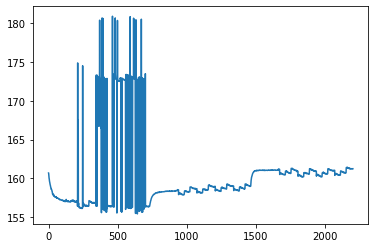

In [258]:
_= plt.plot(PS1.mean(axis=1))

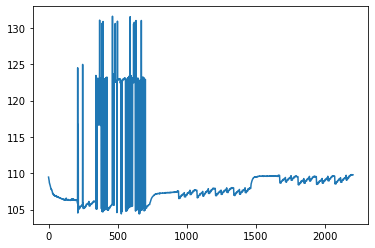

In [259]:
_= plt.plot(PS2.mean(axis=1))

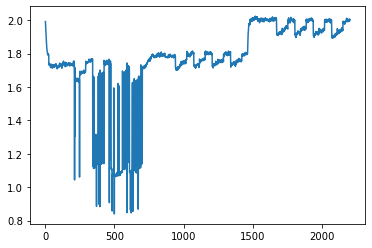

In [260]:
_= plt.plot(PS3.mean(axis=1))

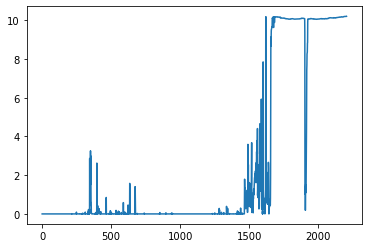

In [261]:
_= plt.plot(PS4.mean(axis=1))

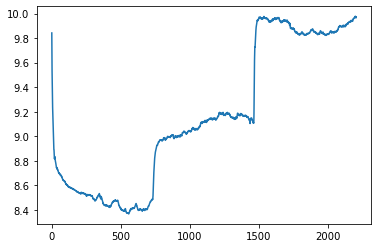

In [262]:
_= plt.plot(PS5.mean(axis=1))

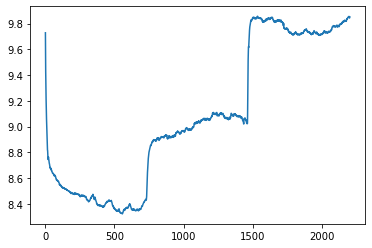

In [263]:
_= plt.plot(PS6.mean(axis=1))

In [264]:
EPS1.describe()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,2341.493968,2341.492971,2341.508571,2341.496054,2341.492517,2341.491429,2341.464580,2341.421406,2341.343129,2341.237551,...,2341.510113,2341.510476,2341.500680,2341.503673,2341.495601,2341.497324,2341.500952,2341.499864,2341.494240,2341.499501
std,76.469325,76.469992,76.478832,76.474371,76.471514,76.461255,76.461135,76.464205,76.459241,76.483519,...,76.392245,76.412298,76.412858,76.432903,76.422931,76.443538,76.443181,76.456539,76.462469,76.460793
min,2227.800000,2227.800000,2227.800000,2227.800000,2226.800000,2227.800000,2227.400000,2226.800000,2226.800000,2226.400000,...,2227.400000,2227.400000,2227.600000,2227.600000,2227.800000,2227.800000,2227.800000,2227.800000,2227.800000,2227.800000
25%,2273.800000,2273.800000,2273.800000,2273.800000,2273.800000,2274.000000,2274.000000,2273.800000,2273.800000,2273.600000,...,2273.800000,2273.800000,2273.800000,2273.800000,2274.000000,2273.800000,2274.000000,2274.000000,2274.000000,2273.800000
50%,2333.800000,2333.800000,2333.800000,2333.800000,2333.600000,2333.600000,2333.600000,2333.600000,2333.600000,2333.600000,...,2333.600000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000,2333.800000
75%,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,2413.600000,...,2413.600000,2413.600000,2413.400000,2413.400000,2413.400000,2413.600000,2413.400000,2413.400000,2413.600000,2413.600000
max,2863.200000,2863.400000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,2863.600000,...,2860.000000,2860.000000,2860.000000,2860.000000,2860.000000,2861.000000,2862.000000,2862.400000,2862.800000,2863.000000


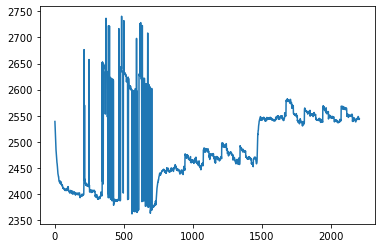

In [265]:
_= plt.plot(EPS1.mean(axis=1))

In [266]:
FS1.describe()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,8.287100,0.857298,0.563584,0.031154,0.003567,0.002926,0.002683,0.002458,0.002436,0.002311,...,7.638567,7.638928,7.642123,7.641907,7.638804,7.643067,7.637415,7.645035,7.638999,7.637983
std,0.480969,0.125100,0.152903,0.039403,0.002810,0.002540,0.002501,0.002410,0.002451,0.002378,...,0.530204,0.529731,0.530209,0.530325,0.529648,0.530317,0.529648,0.530884,0.530817,0.529553
min,7.033000,0.522000,0.309000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.106000,1.117000,1.119000,1.123000,1.109000,1.111000,1.118000,1.120000,1.124000,1.120000
25%,7.961000,0.773000,0.445000,0.009000,0.001000,0.001000,0.000000,0.000000,0.000000,0.000000,...,7.514000,7.515000,7.518000,7.515000,7.519000,7.518000,7.513000,7.525000,7.510000,7.519000
50%,8.278000,0.855000,0.531000,0.016000,0.003000,0.003000,0.003000,0.001000,0.001000,0.001000,...,7.712000,7.709000,7.711000,7.714000,7.706000,7.714000,7.707000,7.713000,7.710000,7.708000
75%,8.610000,0.944000,0.656000,0.036000,0.005000,0.004000,0.004000,0.004000,0.004000,0.004000,...,7.815000,7.815000,7.818000,7.823000,7.813000,7.820000,7.813000,7.821000,7.826000,7.815000
max,11.754000,1.488000,0.985000,0.298000,0.015000,0.013000,0.011000,0.011000,0.012000,0.012000,...,8.060000,8.078000,8.072000,8.064000,8.073000,8.080000,8.076000,8.083000,8.078000,8.087000


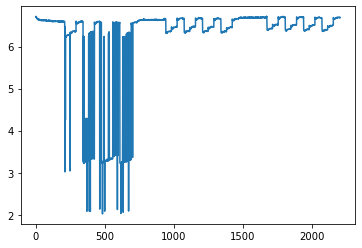

In [267]:
_= plt.plot(FS1.mean(axis=1))

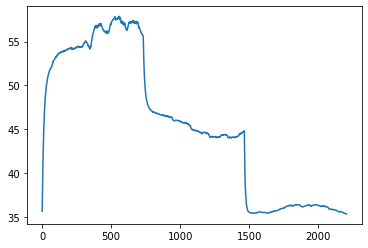

In [268]:
_= plt.plot(TS1.mean(axis=1))

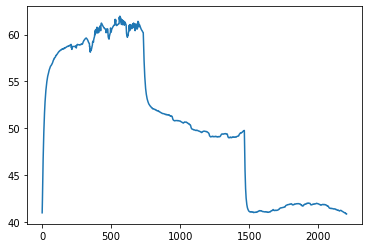

In [269]:
_= plt.plot(TS2.mean(axis=1))

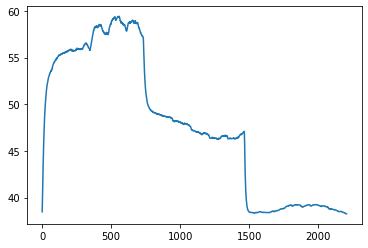

In [270]:
_= plt.plot(TS3.mean(axis=1))

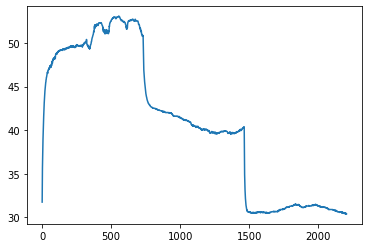

In [271]:
_= plt.plot(TS4.mean(axis=1))

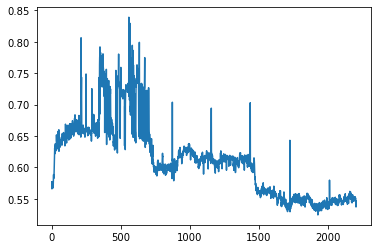

In [272]:
_= plt.plot(VS1.mean(axis=1))

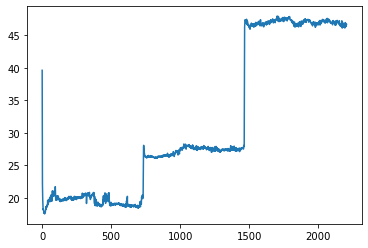

In [273]:
_= plt.plot(CE.mean(axis=1))

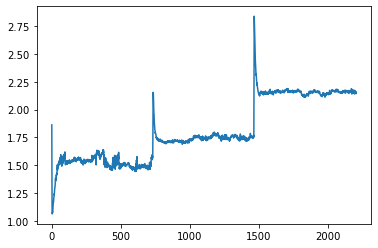

In [274]:
_= plt.plot(CP.mean(axis=1))

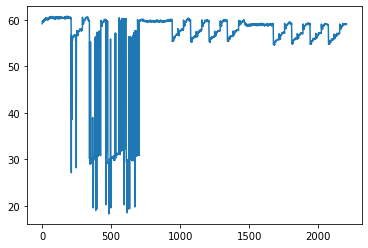

In [275]:
_= plt.plot(SE.mean(axis=1))

### Data preprocessing

In [276]:
PS1_arr= PS1.mean(axis =1)
PS2_arr= PS2.mean(axis =1)
PS3_arr= PS3.mean(axis =1)
PS4_arr= PS4.mean(axis =1)
PS5_arr= PS5.mean(axis =1)
PS6_arr= PS6.mean(axis =1)

In [277]:
df=pd.DataFrame({"PS1":PS1_arr,"PS2":PS2_arr,"PS3":PS3_arr,"PS4":PS4_arr,"PS5":PS5_arr,"PS6":PS6_arr})

In [278]:
df.shape

(2205, 6)

In [279]:
EPS1_arr = EPS1.mean(axis = 1)
df['EPS1'] = EPS1_arr

In [280]:
df.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1
0,160.673492,109.466914,1.991475,0.0,9.842170,9.728097,2538.929167
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000
3,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,2511.541633
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500


In [281]:
FS1_arr = FS1.mean(axis = 1)
df['FS1'] = FS1_arr

FS2_arr = FS2.mean(axis = 1)
df['FS2'] = FS2_arr

TS1_arr = TS1.mean(axis = 1)
df['TS1'] = TS1_arr

TS2_arr = TS2.mean(axis = 1)
df['TS2'] = TS2_arr

TS3_arr = TS3.mean(axis = 1)
df['TS3'] = TS3_arr

TS4_arr = TS4.mean(axis = 1)
df['TS4'] = TS4_arr

VS1_arr = VS1.mean(axis = 1)
df['VS1'] = VS1_arr

CE_arr = CE.mean(axis = 1)
df['CE'] = CE_arr

CP_arr = CP.mean(axis = 1)
df['CP'] = CP_arr

SE_arr = SE.mean(axis = 1)
df['SE'] = SE_arr

In [282]:
df.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE
0,160.673492,109.466914,1.991475,0.0,9.842170,9.728097,2538.929167,6.709815,10.304592,35.621983,40.978767,38.471017,31.745250,0.576950,39.601350,1.862750,59.157183
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,41.532767,38.978967,34.493867,0.565850,25.786433,1.255550,59.335617
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,42.442450,39.631950,35.646150,0.576533,22.218233,1.113217,59.543150
3,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,2511.541633,6.720565,10.302678,38.879050,43.403983,40.403383,36.579467,0.569267,20.459817,1.062150,59.794900
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,44.332750,41.310550,37.427900,0.577367,19.787017,1.070467,59.455267


In [283]:
df_temp=pd.DataFrame(target,columns=target.columns)
df_temp.head()

,Cooler Cond.,Valve Cond.,pump leakage,Hydraulic accm.,stable flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [284]:
df_final=pd.concat([df,df_temp],axis=1)
df_final.head()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,...,TS4,VS1,CE,CP,SE,Cooler Cond.,Valve Cond.,pump leakage,Hydraulic accm.,stable flag
0,160.673492,109.466914,1.991475,0.0,9.842170,9.728097,2538.929167,6.709815,10.304592,35.621983,...,31.745250,0.576950,39.601350,1.862750,59.157183,3,100,0,130,1
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,...,34.493867,0.565850,25.786433,1.255550,59.335617,3,100,0,130,1
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,...,35.646150,0.576533,22.218233,1.113217,59.543150,3,100,0,130,1
3,160.188088,109.064807,1.946575,0.0,9.438827,9.337430,2511.541633,6.720565,10.302678,38.879050,...,36.579467,0.569267,20.459817,1.062150,59.794900,3,100,0,130,1
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,...,37.427900,0.577367,19.787017,1.070467,59.455267,3,100,0,130,1


In [285]:
X = df_final.iloc[:,:-5]
y = df_final.iloc[:,-5:]

### Cooler condition

COOLER CONDITIONS
Benchmark Classifier
F1 score: 0.168432 
Area under the ROC Curve: 0.500000.

Extra Trees Classifier:
F1 score: 1.000000 
Area under the ROC: 1.000000.
 
XGB Classifier:
Area under the ROC Curve for XGB: 1.000000 
F1 score for XBG: 1.000000 

Dummy Classifier Success Rate : 33.53%


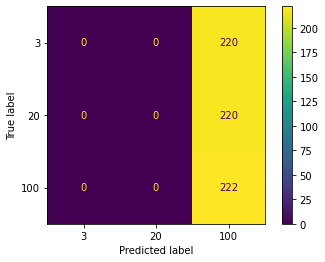

Extra trees Regression Success Rate : 100.00%


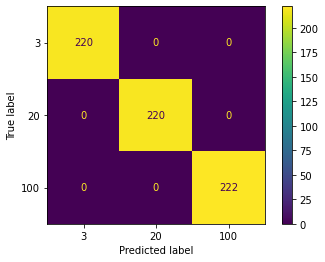

XBoost Classifier Success Rate : 100.00%


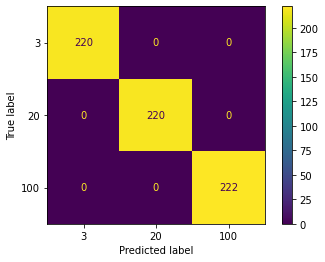

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Cooler Cond.'], test_size = 0.3, shuffle=True, stratify=y['Cooler Cond.'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print('COOLER CONDITIONS')
#Dummy classfier
print('Benchmark Classifier')
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train,y_train)
y_pred= dummy.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =dummy.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve: {:3f}.\n'.format(roc_value))

#ExtratreesClassifier
print('Extra Trees Classifier:')
et = ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
y_pred= et.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =et.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC: {:3f}.\n '.format(roc_value))

#For XGB
print('XGB Classifier:')
xgb = XGBClassifier(scale_pos_weight=100)
xgb.fit(X_train,y_train)
y_pred_proba= xgb.predict_proba(X_test)
y_pred= xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {:3f} '.format(roc_value))
print('F1 score for XBG: {:3f} \n'.format(f1_score(y_test, y_pred, average='weighted')))

x_predict=dummy.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(dummy, X_test, y_test)
plt.show()

x_predict=et.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

x_predict = xgb.predict(X_test)
s3=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s3))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

### Valve conditions 

VALVE CONDITIONS
Benchmark Classifier
F1 score: 0.345148 
Area under the ROC Curve: 0.500000.

Extra Trees Classifier:
F1 score: 0.963590 
Area under the ROC: 0.996877.
 
XGB Classifier:
Area under the ROC Curve for XGB: 0.981586 
F1 score for XBG: 0.917157 

Dummy Classifier Success Rate : 51.06%


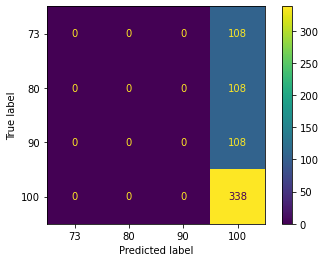

Extra trees Regression Success Rate : 96.37%


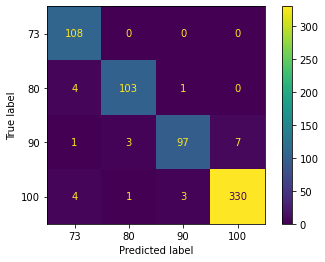

XBoost Classifier Success Rate : 91.99%


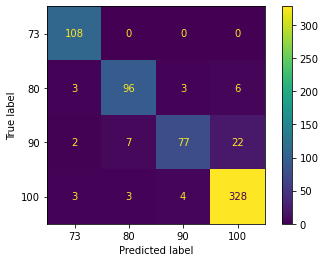

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Valve Cond.'], test_size = 0.3, shuffle=True, stratify=y['Valve Cond.'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('VALVE CONDITIONS')
#Dummy classfier
print('Benchmark Classifier')
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train,y_train)
y_pred= dummy.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =dummy.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve: {:3f}.\n'.format(roc_value))

#ExtratreesClassifier
print('Extra Trees Classifier:')
et = ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
y_pred= et.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =et.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC: {:3f}.\n '.format(roc_value))

#For XGB
print('XGB Classifier:')
xgb = XGBClassifier(scale_pos_weight=100)
xgb.fit(X_train,y_train)
y_pred_proba= xgb.predict_proba(X_test)
y_pred= xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {:3f} '.format(roc_value))
print('F1 score for XBG: {:3f} \n'.format(f1_score(y_test, y_pred, average='weighted')))

x_predict=dummy.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(dummy, X_test, y_test)
plt.show()

x_predict=et.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

x_predict = xgb.predict(X_test)
s3=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s3))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

### Pump leakage

PUMP LEAKAGE

Benchmark Classifier
F1 score: 0.393678 
Area under the ROC Curve: 0.500000.

Extra Trees Classifier:
F1 score: 0.993969 
Area under the ROC: 0.999984.
 
XGB Classifier:
Area under the ROC Curve for XGB: 0.999954 
F1 score for XBG: 0.995480 

Dummy Classifier Success Rate : 55.29%


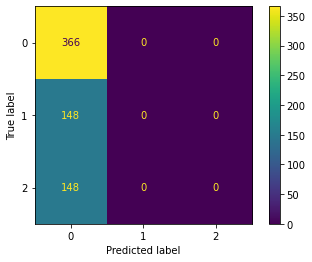

Extra trees Regression Success Rate : 99.40%


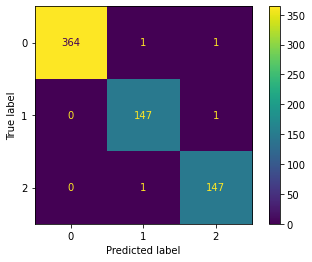

XBoost Classifier Success Rate : 99.55%


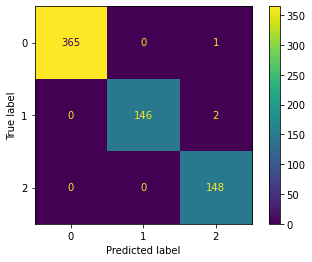

In [288]:
X_train, X_test, y_train, y_test = train_test_split(X, y['pump leakage'], test_size = 0.3, shuffle=True, stratify=y['pump leakage'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('PUMP LEAKAGE\n')
#Dummy classfier
print('Benchmark Classifier')
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train,y_train)
y_pred= dummy.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =dummy.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve: {:3f}.\n'.format(roc_value))

#ExtratreesClassifier
print('Extra Trees Classifier:')
et = ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
y_pred= et.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =et.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC: {:3f}.\n '.format(roc_value))

#For XGB
print('XGB Classifier:')
xgb = XGBClassifier(scale_pos_weight=100)
xgb.fit(X_train,y_train)
y_pred_proba= xgb.predict_proba(X_test)
y_pred= xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {:3f} '.format(roc_value))
print('F1 score for XBG: {:3f} \n'.format(f1_score(y_test, y_pred, average='weighted')))

x_predict=dummy.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(dummy, X_test, y_test)
plt.show()

x_predict=et.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

x_predict = xgb.predict(X_test)
s3=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s3))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()

### Hydraulic accm.

HYDRAULIC ACCM.
Benchmark Classifier
F1 score: 0.195720 
Area under the ROC Curve: 0.500000.

Extra Trees Classifier:
F1 score: 0.987985 
Area under the ROC: 0.999842.
 
XGB Classifier:
Area under the ROC Curve for XGB: 0.995883 
F1 score for XBG: 0.952065 

Dummy Classifier Success Rate : 36.56%


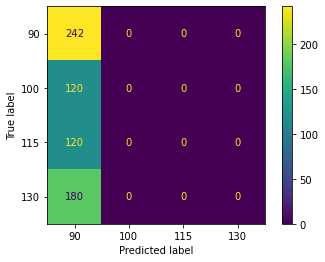

Extra trees Regression Success Rate : 98.79%


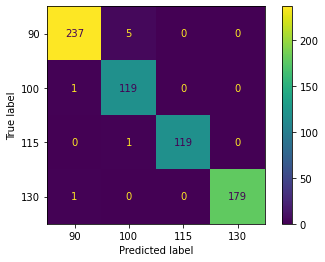

XBoost Classifier Success Rate : 95.17%


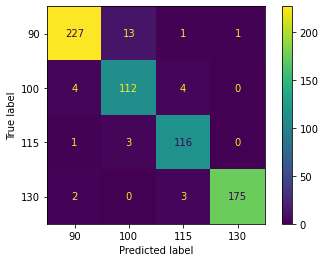

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y['Hydraulic accm.'], test_size = 0.3, shuffle=True, stratify=y['Hydraulic accm.'])
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('HYDRAULIC ACCM.')
#Dummy classfier
print('Benchmark Classifier')
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train,y_train)
y_pred= dummy.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =dummy.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve: {:3f}.\n'.format(roc_value))

#ExtratreesClassifier
print('Extra Trees Classifier:')
et = ExtraTreesClassifier(n_estimators=1000)
et.fit(X_train,y_train)
y_pred= et.predict(X_test)
print('F1 score: {:3f} '.format(f1_score(y_test, y_pred, average='weighted')))
y_pred_proba =et.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC: {:3f}.\n '.format(roc_value))

#For XGB
print('XGB Classifier:')
xgb = XGBClassifier(scale_pos_weight=100)
xgb.fit(X_train,y_train)
y_pred_proba= xgb.predict_proba(X_test)
y_pred= xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
roc_value =roc_auc_score(y_test,y_pred_proba, multi_class='ovr',average ='weighted')
print('Area under the ROC Curve for XGB: {:3f} '.format(roc_value))
print('F1 score for XBG: {:3f} \n'.format(f1_score(y_test, y_pred, average='weighted')))

x_predict=dummy.predict(X_test)
s1=accuracy_score(y_test,x_predict)
print("Dummy Classifier Success Rate :", "{:.2f}%".format(100*s1))
plot_confusion_matrix(dummy, X_test, y_test)
plt.show()

x_predict=et.predict(X_test)
s2=accuracy_score(y_test,x_predict)
print("Extra trees Regression Success Rate :", "{:.2f}%".format(100*s2))
plot_confusion_matrix(et, X_test, y_test)
plt.show()

x_predict = xgb.predict(X_test)
s3=accuracy_score(y_test,x_predict)
print("XBoost Classifier Success Rate :", "{:.2f}%".format(100*s3))
plot_confusion_matrix(xgb, X_test, y_test)
plt.show()